# Lab 1: Image enhancement
## Introduction
In this first lab, we will introduce some of the conventional methods using for image enhancement. The goal at this stage is to improve the quality of the image so that the relevant features can be extracted easily. We will start with 1D signals for simplicity and move to 2D images later. We will mostly focus on the practical aspect while the theory behind each algorithm is presented in greater depth in some of the books and papers attached.\
We will be using the open-source python library OpenCV (cv2) for this exercise alongside interactive widgets (ipywidgets) for better visibility.\
Interesting (albeit old-ish) tutorials can be found in the OpenCV website : https://docs.opencv.org/4.x/d2/d96/tutorial_py_table_of_contents_imgproc.html

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cv2
from skimage.restoration import denoise_tv_bregman as anisotropic_diffusion
import ipywidgets

## 1) Image structure
We will start by opening one of the PLIF demo images provided in the "data" folder. Most experimental images are acquired in single-channel (grayscale) with 8- and 16-bit depths being the most common. In this lab, we will consider 8-bit images.

In [2]:
img_id = "sweeney1.png"
img = cv2.imread(f"data/{img_id}",0)
img = img.astype(np.uint8)

Every pixel in the image should contain an intensity $i$ within the dynamic range $[0,\,2^8-1]$:
\begin{align}
i \in [0,\,255]
\end{align}
This can be better visualized by plotting the image histogram.

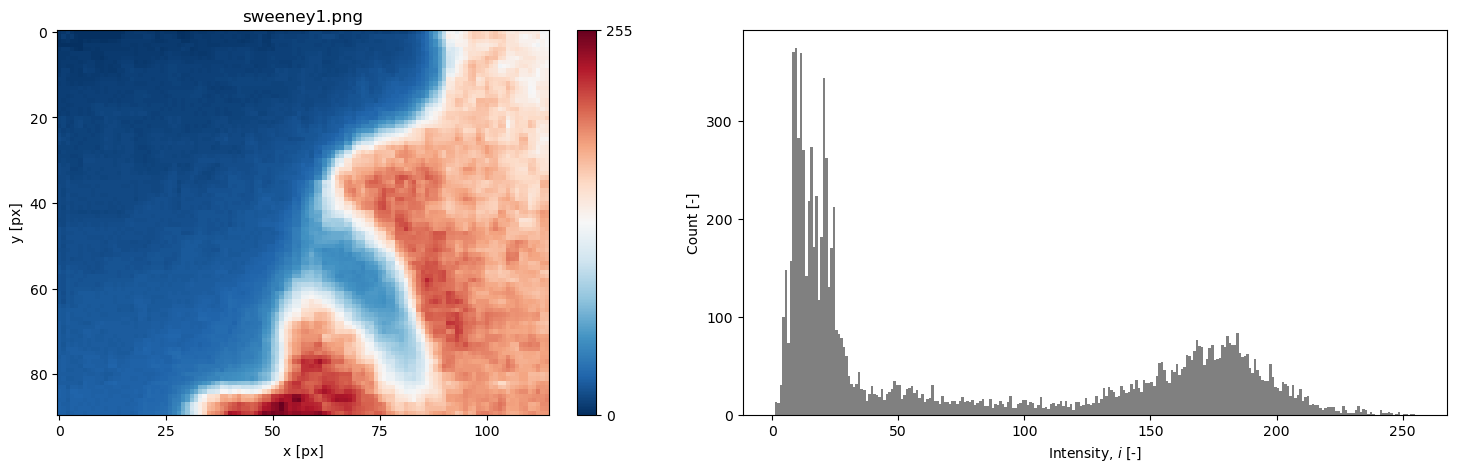

In [3]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))

plt.subplot(121)
plt.imshow(img, cmap='RdBu_r', vmin=0, vmax=255)
plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
plt.xlabel("x [px]")
plt.ylabel("y [px]")
plt.title(img_id)

plt.subplot(122)
plt.hist(img.flatten(), bins = np.arange(1,256,1),color='grey',alpha = 1)
plt.xlabel("Intensity, $i$ [-]")
plt.ylabel("Count [-]")

plt.rcParams.update({'font.size': 20})

plt.show()


Often, PLIF image histograms will display a bimodal distribution corresponding the reactant (low intensities) and product (high intensities) regions. The variance of the latter is typically larger due to higher noise intensity on the product side.

## 2) Visualizing the image histogram
A way to get an intuitive approach to the histogram shown previously is to apply a thresholding operation the image. Thresholding, in this context, is akin to a high-pass filter which only accepts intensities larger than the threshold specified. 

In [4]:
def segmentation_example(thresh=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    plt.subplot(121)
    _,img1 = cv2.threshold(img,thresh,255,cv2.THRESH_BINARY)
    img1 = (img1/255)
    img1 = img1.astype(int)
    plt.imshow(img1, cmap='gray', vmin=0, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title(img_id)
    plt.subplot(122)
    plt.hist(img.flatten()*(img1.flatten()), bins = np.arange(1,256,1),color='grey',alpha = 1)
    plt.hist(img.flatten()*(1-img1.flatten()), bins = np.arange(1,256,1),color='grey', alpha = .2)
    plt.axvline(x=thresh+1,color = 'r', linestyle = '--', linewidth = 1)
    plt.xlabel("Intensity, $i$ [-]")
    plt.ylabel("Count [-]")
    plt.ylim(0,400)
    plt.rcParams.update({'font.size': 20})
    plt.show()

ipywidgets.interact(segmentation_example, thresh = (1,255,round(255/6)))

interactive(children=(IntSlider(value=1, description='thresh', max=255, min=1, step=42), Output()), _dom_class…

<function __main__.segmentation_example(thresh=1)>

By changing the value of the threshold (dashed red line in the histogram), one can "segment" the image into two regions: a foreground (brightest pixels) and a background (darker pixels). A binary representation is often used with foreground pixels being assigned values of ones and background pixels zeros. This intuitive visualization of the histogram will prove useful when we discuss segmentation as a flame front detection approach (notice how setting the threshold to a value close to 100 does a decent job at isolating the unburnt and burnt regions).

## 3) Image filtering
In this section, we will introduce some of the popular filtering schemes for this type of images. Distinction should be made between linear and non-linear filters. The choice of filters is in general dependent on the nature of the investigation, but non-linear filters tend to produce good results in edge detection applications as they preserve the location and magnitude of gradients in the vicinity of the flame front.\
\
In this lab, we will be looking at four filters: the box filter (*L*), the Gaussian filter (*L*), the median filter (*NL*), the nonlinear/anisotropic diffusion filter (*NL*). We will be using interactive widgets to visualize the effect of filtering parameters on the obtained image.\
\
To assess the extent of filtering, we will be referring to the signal-to-noise ratio which, in this lab, will be defined using the following expression :
\
\
\begin{align}
\text{SNR} = \frac{\mu_{burnt} - \mu_{unburnt}}{\sigma_{burnt}}
\end{align}
where $\mu$ and $\sigma$ correspond to the mean and standard deviation of OH intensities in the product (burnt) or reactant (unburnt) regions. Instead of evaluating these statistics over the whole burnt or unburnt region respectively, and because we cannot separate both accurately a priori, we will evaluate them over identical boxes of size $d = 15\times15$ placed in the respective region as shown in the images below.

In [5]:
d = 15

### 2.1) Linear filters
#### 2.1.1) Box filter
The box (or moving-mean) filter is the most basic linear filter. As its name indicates, it consists in a simple averaging operation at a given pixel in the image based on the values of its neighboring pixels. The kernel assigns the same weight to all pixels within the box and they should all sum up to 1. To avoid image distortion, isotropic kernels are preferred.\
\
*Example*: The istropic box filter of width $3\times3$ takes the shape : 
\begin{align}
H = \frac{1}{9}\,
\begin{pmatrix}
1 & 1 & 1\\
1 & 1 & 1\\
1 & 1 & 1
\end{pmatrix}
\end{align}

In [6]:
def fbox(width=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(121)
    img1 = cv2.boxFilter(img,-1, (width,width))
    img1 = 255*(img1/img1.max())
    img2 = img1+0;
    cv2.rectangle(img2, (20, 60), (20+d, 60+d), np.array([255,255,255])/2, 1)
    cv2.rectangle(img2, (95, 30), (95+d, 30+d), np.array([0,0,0])/2, 1)
    unburnt_box = img1[60:60+d,20:20+d]
    burnt_box = img1[30:30+d,95:95+d]
    SNR = (np.mean(burnt_box) - np.mean(unburnt_box))/np.std(burnt_box)
    plt.imshow(img2, cmap='RdBu_r', vmin=0, vmax=255)
    plt.text(5,10,f"SNR={SNR:.3}",color = "w")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Box filter")
    plt.subplot(122)
    thr1 = 0
    thr2 = 0
    aperture_sz = 7
    edges = cv2.Canny(img1.astype(np.uint8), threshold1 = thr1*255, threshold2 = thr2*255, apertureSize=aperture_sz, L2gradient=True)
    edges = edges/255
    # Compute the gradient in the x direction
    gradient_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=aperture_sz)
    # Compute the gradient in the y direction
    gradient_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=aperture_sz)
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    G = G/np.max(G)
    plt.imshow(edges*G, cmap='RdBu_r', vmin=0.2, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Canny edge detection")
    plt.rcParams.update({'font.size': 20})
    plt.show()

ipywidgets.interact(fbox, width = (1,25,4))

interactive(children=(IntSlider(value=1, description='width', max=25, min=1, step=4), Output()), _dom_classes=…

<function __main__.fbox(width=1)>

#### 2.1.2) Gaussian filter
The Gaussian filter is another popular state-of-the-art linear filter. It is defined as a two-dimensional Gaussian kernel of standard deviation $\sigma$:
\begin{align}
G_\sigma(x,z) = \frac{1}{2\pi \sigma^2} e^{-\frac{x^2+y^2}{2\sigma^2}}
\end{align}
The standard deviation alongside the kernel width control the extent of filtering.

In [7]:
def fgauss(sigma=1,width=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(121)
    img1 = cv2.GaussianBlur(img,(width,width),sigma,sigma,0)
    img1 = 255*(img1/img1.max())
    img2 = img1+0;
    cv2.rectangle(img2, (20, 60), (20+d, 60+d), np.array([255,255,255])/2, 1)
    cv2.rectangle(img2, (95, 30), (95+d, 30+d), np.array([0,0,0])/2, 1)
    unburnt_box = img1[60:60+d,20:20+d]
    burnt_box = img1[30:30+d,95:95+d]
    SNR = (np.mean(burnt_box) - np.mean(unburnt_box))/np.std(burnt_box)
    plt.imshow(img2, cmap='RdBu_r', vmin=0, vmax=255)
    plt.text(5,10,f"SNR={SNR:.3}",color = "w")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Gaussian filter")
    plt.subplot(122)
    thr1 = 0
    thr2 = 0
    aperture_sz = 7
    edges = cv2.Canny(img1.astype(np.uint8), threshold1 = thr1*255, threshold2 = thr2*255, apertureSize=aperture_sz, L2gradient=True)
    edges = edges/255
    # Compute the gradient in the x direction
    gradient_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=aperture_sz)
    # Compute the gradient in the y direction
    gradient_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=aperture_sz)
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    G = G/np.max(G)
    plt.imshow(edges*G, cmap='RdBu_r', vmin=0.2, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Canny edge detection")
    plt.rcParams.update({'font.size': 20})
    plt.show()

ipywidgets.interact(fgauss, sigma = (1,9,1), width = (1,25,4))

interactive(children=(IntSlider(value=1, description='sigma', max=9, min=1), IntSlider(value=1, description='w…

<function __main__.fgauss(sigma=1, width=1)>

### 2.2) Non-linear filters
#### 2.2.1) Median filter
--
-------

In [8]:
def fmedian(width=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(121)
    img1 = cv2.medianBlur(img,width)
    img1 = 255*(img1/np.max(img1))
    img2 = img1+0;
    cv2.rectangle(img2, (20, 60), (20+d, 60+d), np.array([255,255,255])/2, 1)
    cv2.rectangle(img2, (95, 30), (95+d, 30+d), np.array([0,0,0])/2, 1)
    unburnt_box = img1[60:60+d,20:20+d]
    burnt_box = img1[30:30+d,95:95+d]
    SNR = (np.mean(burnt_box) - np.mean(unburnt_box))/np.std(burnt_box)
    plt.imshow(img2, cmap='RdBu_r', vmin=0, vmax=255)
    plt.text(5,10,f"SNR={SNR:.3}",color = "w")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Median filter")
    plt.subplot(122)
    thr1 = 0
    thr2 = 0
    aperture_sz = 7
    edges = cv2.Canny(img1.astype(np.uint8), threshold1 = thr1*255, threshold2 = thr2*255, apertureSize=aperture_sz, L2gradient=True)
    edges = edges/255
    # Compute the gradient in the x direction
    gradient_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=aperture_sz)
    # Compute the gradient in the y direction
    gradient_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=aperture_sz)
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    G = G/np.max(G)
    plt.imshow(edges*G, cmap='RdBu_r', vmin=0.2, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Canny edge detection")
    plt.rcParams.update({'font.size': 20})
    plt.show()
    
ipywidgets.interact(fmedian, width = (1,25,4))

interactive(children=(IntSlider(value=1, description='width', max=25, min=1, step=4), Output()), _dom_classes=…

<function __main__.fmedian(width=1)>

#### 2.2.1) Anisotropic diffusion filter
--
-------

In [9]:
def fnld(N=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(121)
    img1 = anisotropic_diffusion(img,weight = .5,max_num_iter=N)
    unburnt_box = img1[60:60+d,20:20+d]
    burnt_box = img1[30:30+d,95:95+d]
    img1 = 255*(img1/img1.max())
    img2 = img1+0;
    img2 = img1.astype(np.uint8)
    cv2.rectangle(img2, (20, 60), (20+d, 60+d), np.array([255,255,255])/2, 1)
    cv2.rectangle(img2, (95, 30), (95+d, 30+d), np.array([0,0,0])/2, 1)
    SNR = (np.mean(burnt_box) - np.mean(unburnt_box))/np.std(burnt_box)
    plt.imshow(img2, cmap='RdBu_r', vmin=0, vmax=255)
    plt.text(5,10,f"SNR={SNR:.3}",color = "w")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Total variation filter")
    plt.subplot(122)
    thr1 = 0
    thr2 = 0
    aperture_sz = 7
    edges = cv2.Canny(img1.astype(np.uint8), threshold1 = thr1*255, threshold2 = thr2*255, apertureSize=aperture_sz, L2gradient=True)
    edges = edges/255
    # Compute the gradient in the x direction
    gradient_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=aperture_sz)
    # Compute the gradient in the y direction
    gradient_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=aperture_sz)
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    G = G/np.max(G)
    plt.imshow(edges*G, cmap='RdBu_r', vmin=0.2, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Canny edge detection")
    plt.rcParams.update({'font.size': 20})
    plt.show()
    #plt.imshow(G, cmap='RdBu_r', vmin=np.min(G.flatten()), vmax=np.max(G.flatten()))

ipywidgets.interact(fnld, N = (1,24,4))

interactive(children=(IntSlider(value=1, description='N', max=24, min=1, step=4), Output()), _dom_classes=('wi…

<function __main__.fnld(N=1)>

# Canny edge detection (test)

In [10]:
def fcanny(N=1):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))
    plt.subplot(121)
    img1 = anisotropic_diffusion(img,weight = .1,max_num_iter=N)
    unburnt_box = img1[60:60+d,20:20+d]
    burnt_box = img1[30:30+d,95:95+d]
    img1 = 255*(img1/img1.max())
    img2 = img1+0;
    img2 = img1.astype(np.uint8)
    cv2.rectangle(img2, (20, 60), (20+d, 60+d), np.array([255,255,255])/2, 1)
    cv2.rectangle(img2, (95, 30), (95+d, 30+d), np.array([0,0,0])/2, 1)
    SNR = (np.mean(burnt_box) - np.mean(unburnt_box))/np.std(burnt_box)
    plt.imshow(img2, cmap='RdBu_r', vmin=0, vmax=255)
    plt.text(5,10,f"SNR={SNR:.3}",color = "w")
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 255])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Total variation filter")
    plt.subplot(122)
    thr1 = 0
    thr2 = 0
    aperture_sz = 7
    edges = cv2.Canny(img1.astype(np.uint8), threshold1 = thr1*255, threshold2 = thr2*255, apertureSize=aperture_sz, L2gradient=True)
    edges = edges/255
    # Compute the gradient in the x direction
    gradient_x = cv2.Sobel(img1, cv2.CV_64F, 1, 0, ksize=aperture_sz)
    # Compute the gradient in the y direction
    gradient_y = cv2.Sobel(img1, cv2.CV_64F, 0, 1, ksize=aperture_sz)
    G = np.sqrt(gradient_x**2 + gradient_y**2)
    G = G/np.max(G)
    plt.imshow(edges*G, cmap='RdBu_r', vmin=0.2, vmax=1)
    plt.colorbar(fraction=0.035, pad=0.04,ticks=[0, 1])
    plt.xlabel("x [px]")
    plt.ylabel("y [px]")
    plt.title("Canny edge detection")
    plt.rcParams.update({'font.size': 20})
    plt.show()

ipywidgets.interact(fcanny, N = (1,24,4))

interactive(children=(IntSlider(value=1, description='N', max=24, min=1, step=4), Output()), _dom_classes=('wi…

<function __main__.fcanny(N=1)>